In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

from predictor import generate_confusion_matrix
from utils import label_to_idx

# Model evaluation on test data

In [2]:
info_dict = {}

for experiment in ["combined", "gram-positive", "gram-negative", "fungi", "acid-fast"]:
    for fingerprint, model in tqdm(
        list(
            product(
                ["ecfp8", "rdkit", "maccs", "chem_phys", "mhfp6", "erg"],
                ["rf", "xgboost"],
            )
        )
    ):

        report_df, confusion_matrix, fpr_list, tpr_list, matrix_labels = (
            generate_confusion_matrix(
                fingerprint_name=fingerprint,
                model_name=model,
                exp_type=experiment,
                label_classes=label_to_idx,
            )
        )
        report_df["experiment"] = experiment

        info_dict[f"{experiment}_{fingerprint}_{model}"] = {
            "report": report_df,
            "confusion_matrix": confusion_matrix,
            "fpr_list": fpr_list,
            "tpr_list": tpr_list,
            "confusion_matrix_labels": matrix_labels,
        }
    break

100%|██████████| 12/12 [00:16<00:00,  1.42s/it]


In [3]:
metric_df = pd.concat([data_dict["report"] for _, data_dict in info_dict.items()])
metric_df.sort_values(
    by=["cohen_kappa", "roc_auc"], ascending=[False, False], inplace=True
)
metric_df = metric_df.round(3)
metric_df

,accuracy,cohen_kappa,macro_precision,macro_recall,macro_f1,roc_auc,experiment
mhfp6_rf,0.759,0.678,0.775,0.756,0.764,0.845,combined
ecfp8_rf,0.752,0.670,0.765,0.753,0.758,0.843,combined
rdkit_rf,0.743,0.659,0.752,0.746,0.749,0.838,combined
rdkit_xgboost,0.743,0.658,0.751,0.744,0.748,0.837,combined
maccs_rf,0.732,0.645,0.728,0.739,0.733,0.834,combined
mhfp6_xgboost,0.732,0.645,0.736,0.736,0.734,0.832,combined
erg_rf,0.725,0.636,0.727,0.725,0.726,0.826,combined
maccs_xgboost,0.706,0.614,0.692,0.719,0.703,0.821,combined
ecfp8_xgboost,0.686,0.587,0.680,0.691,0.682,0.804,combined
chem_phys_rf,0.686,0.585,0.671,0.680,0.675,0.799,combined


In [4]:
os.makedirs("../data/predictions", exist_ok=True)
metric_df.to_csv("../data/predictions/combined_test_metrics.tsv", sep="\t")

# AUC-ROC Comparison across fingerprints

Since RFs performed the best, the rest models were ommited.

In [5]:
labels = []
fpr_list = []
tpr_list = []

for fingerprint, info in info_dict.items():
    if "rf" not in fingerprint:
        continue

    fingerprint = fingerprint.split("_", 1)[1]
    if len(fingerprint.split("_")) > 2:
        fingerprint = fingerprint.replace("_", "", 1)

    fingerprint = fingerprint.split("_")[0]

    if fingerprint == "chemphys":
        fingerprint = "ChemPhys"
    elif fingerprint == "erg":
        fingerprint = "ErG"
    else:
        fingerprint = fingerprint.upper()

    labels.append(fingerprint)
    fpr_list.append(info["fpr_list"])
    tpr_list.append(info["tpr_list"])

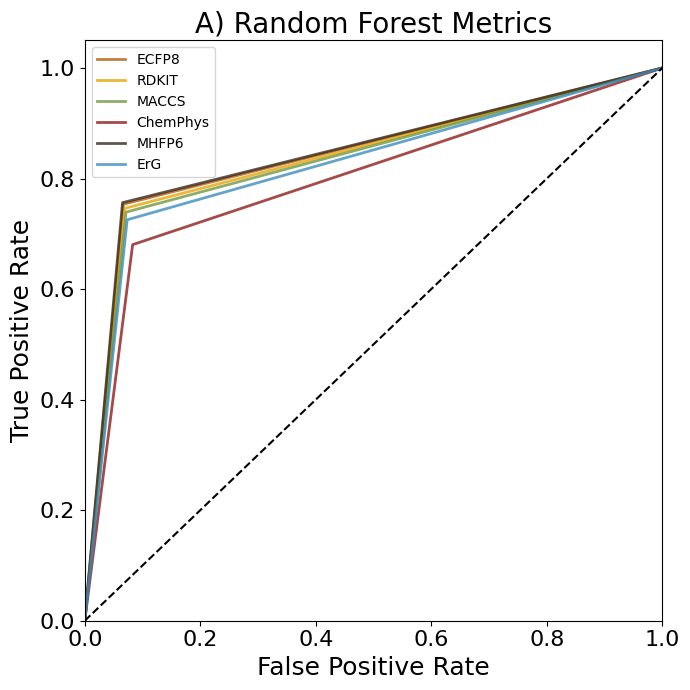

In [6]:
plt.figure(figsize=(7, 7))

colors = {
    "MHFP6": "#3a2c20",
    "ECFP8": "#b65c11",
    "RDKIT": "#e7a504",
    "MACCS": "#719842",
    "ErG": "#3d8ebf",
    "ChemPhys": "#901b1b",
}

for i in range(len(fpr_list)):
    c = colors[labels[i].split("_")[0]]

    sns.lineplot(
        x=fpr_list[i],
        y=tpr_list[i],
        markers=True,
        dashes=False,
        linewidth=2,
        alpha=0.8,
        label=labels[i],
        color=c,
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("A) Random Forest Metrics", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("../figures/figure_6a", dpi=400)
plt.show()

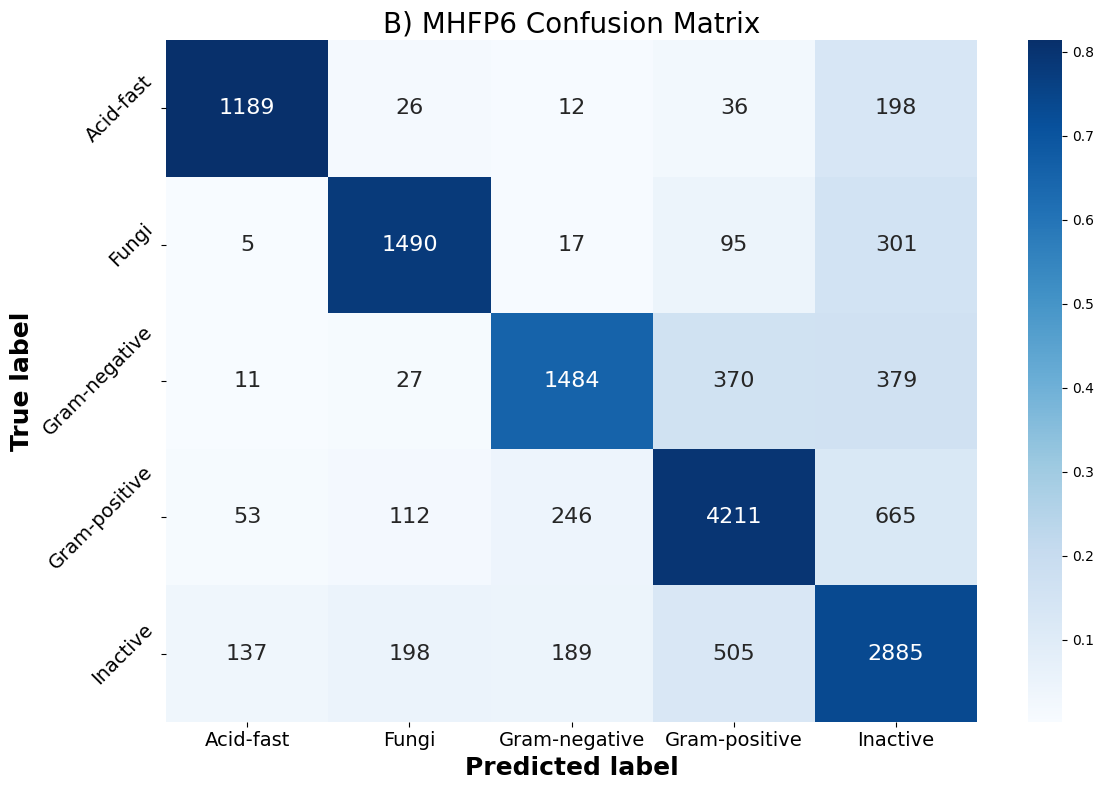

In [7]:
plt.figure(figsize=(12, 8))

# Confusion matrix for best model
best_model_label = metric_df["experiment"][0] + "_" + metric_df.index[0]
cm = info_dict[best_model_label]["confusion_matrix"]
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
label_classes = info_dict[best_model_label]["confusion_matrix_labels"]
fingerprint_name = best_model_label.split("_", maxsplit=2)[1]

sns.heatmap(
    cm_norm,
    annot=cm,
    fmt="d",
    cmap="Blues",
    yticklabels=[i.capitalize() for i in label_classes],
    xticklabels=[i.capitalize() for i in label_classes],
    annot_kws={"size": 16},
)
plt.xlabel("Predicted label", fontsize=18, fontweight="bold")
plt.ylabel("True label", fontsize=18, fontweight="bold")
plt.title(f"B) {fingerprint_name.upper()} Confusion Matrix", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, rotation=45)

plt.tight_layout()
plt.savefig("../figures/figure_6b.png", dpi=400)
plt.show()

# Other metrics

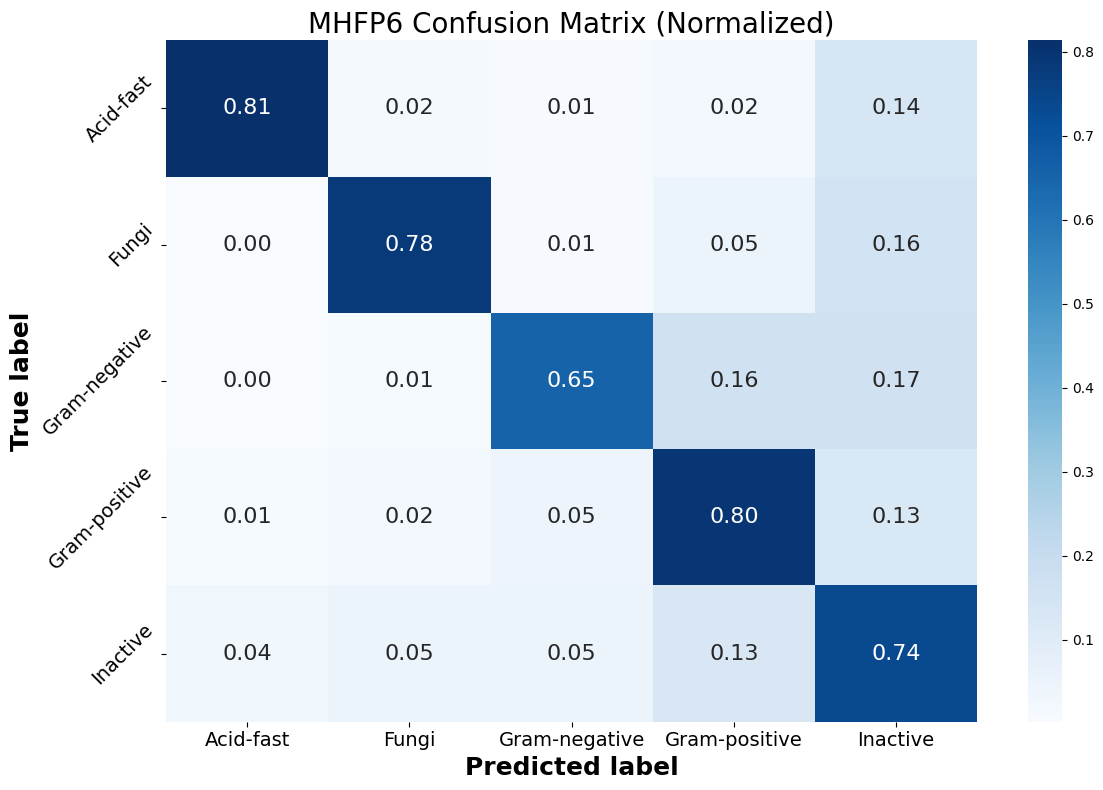

In [8]:
# confusion matrix with percentages
plt.figure(figsize=(12, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    yticklabels=[i.capitalize() for i in label_classes],
    xticklabels=[i.capitalize() for i in label_classes],
    annot_kws={"size": 16},
)
plt.xlabel("Predicted label", fontsize=18, fontweight="bold")
plt.ylabel("True label", fontsize=18, fontweight="bold")
plt.title(f"{fingerprint_name.upper()} Confusion Matrix (Normalized)", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, rotation=45)

plt.tight_layout()
# plt.savefig("../figures/figure_6c.png", dpi=400)
plt.show()

In [9]:
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)

# Specificity or true negative rate
TNR = TN / (TN + FP)

# Precision or positive predictive value
PPV = TP / (TP + FP)

# Negative predictive value
NPV = TN / (TN + FN)

# Fall out or false positive rate
FPR = FP / (FP + TN)

# False negative rate
FNR = FN / (TP + FN)
# False discovery rate
FDR = FP / (TP + FP)

# Overall accuracy
ACC = (TP + TN) / (TP + FP + FN + TN)

pd.DataFrame(
    {
        "TPR": TPR,
        "TNR": TNR,
        "PPV": PPV,
        "NPV": NPV,
        "FPR": FPR,
        "FNR": FNR,
        "ACC": ACC,
    },
    index=label_classes,
).round(3)

,TPR,TNR,PPV,NPV,FPR,FNR,ACC
acid-fast,0.814,0.985,0.852,0.980,0.015,0.186,0.968
fungi,0.781,0.972,0.804,0.968,0.028,0.219,0.947
gram-negative,0.653,0.963,0.762,0.939,0.037,0.347,0.916
gram-positive,0.796,0.895,0.807,0.888,0.105,0.204,0.860
inactive,0.737,0.859,0.652,0.901,0.141,0.263,0.827
